In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


1237665427556794450.npy
1237662236943712440.npy
1237665567145721987.npy
1237664295831011528.npy
1237663789031882921.npy


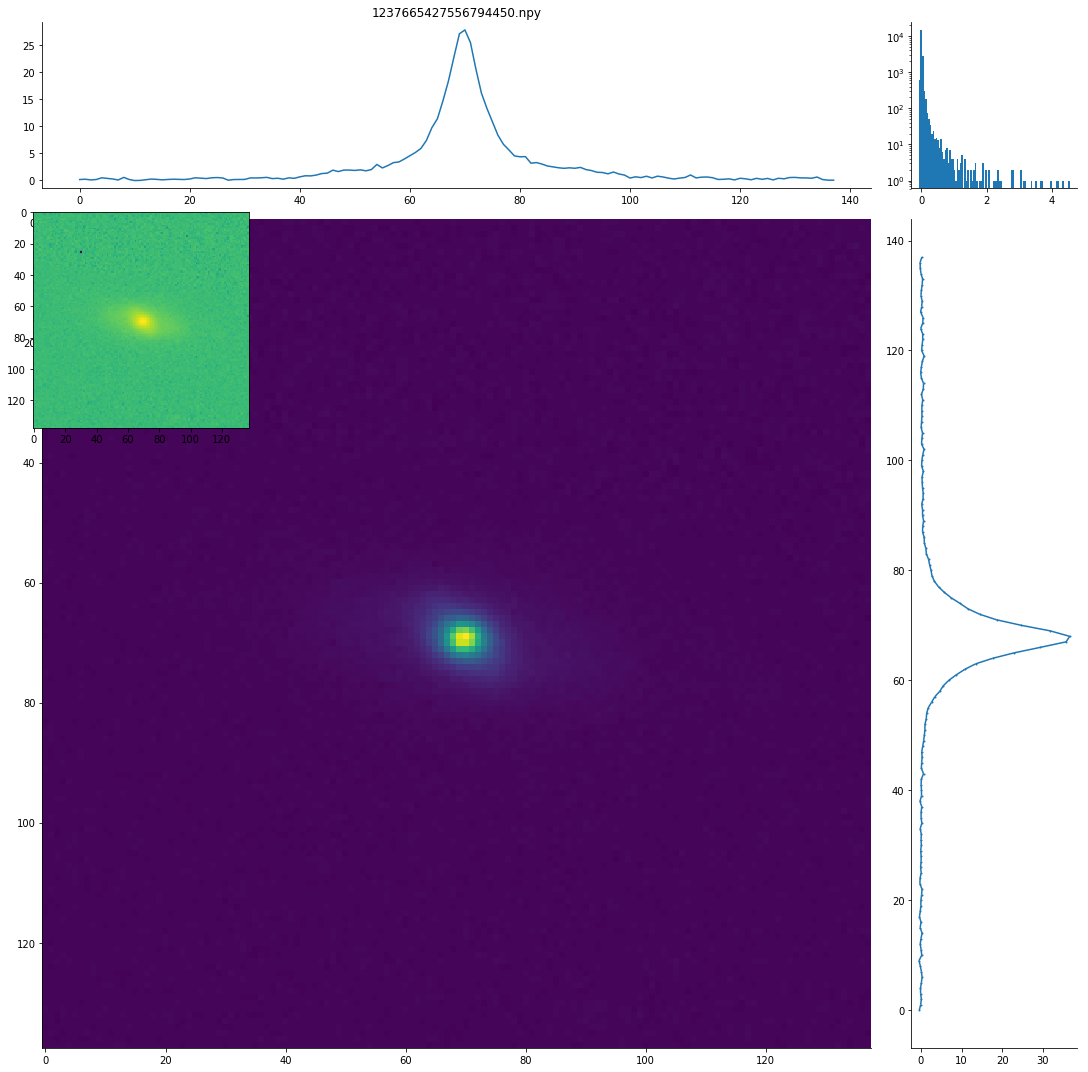

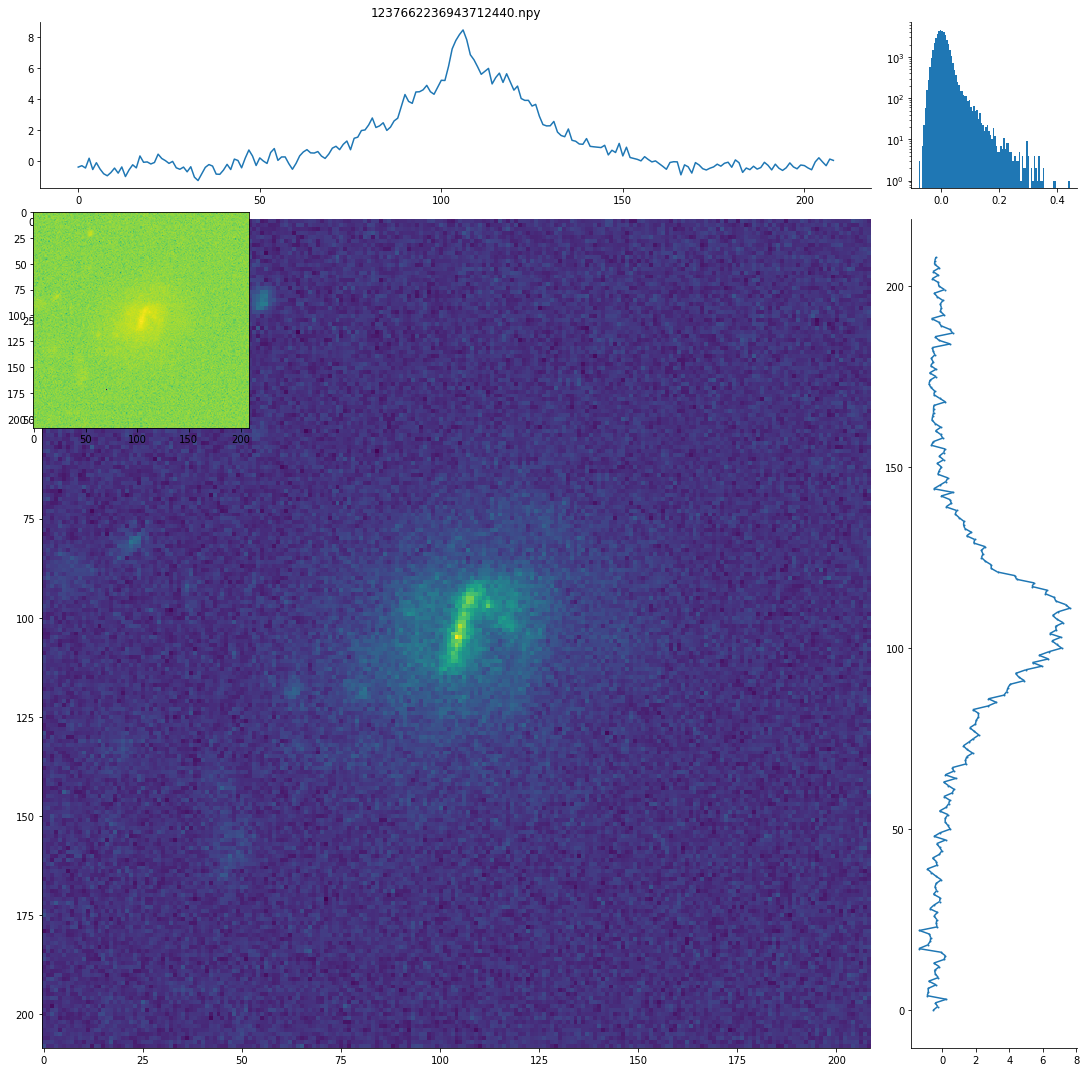

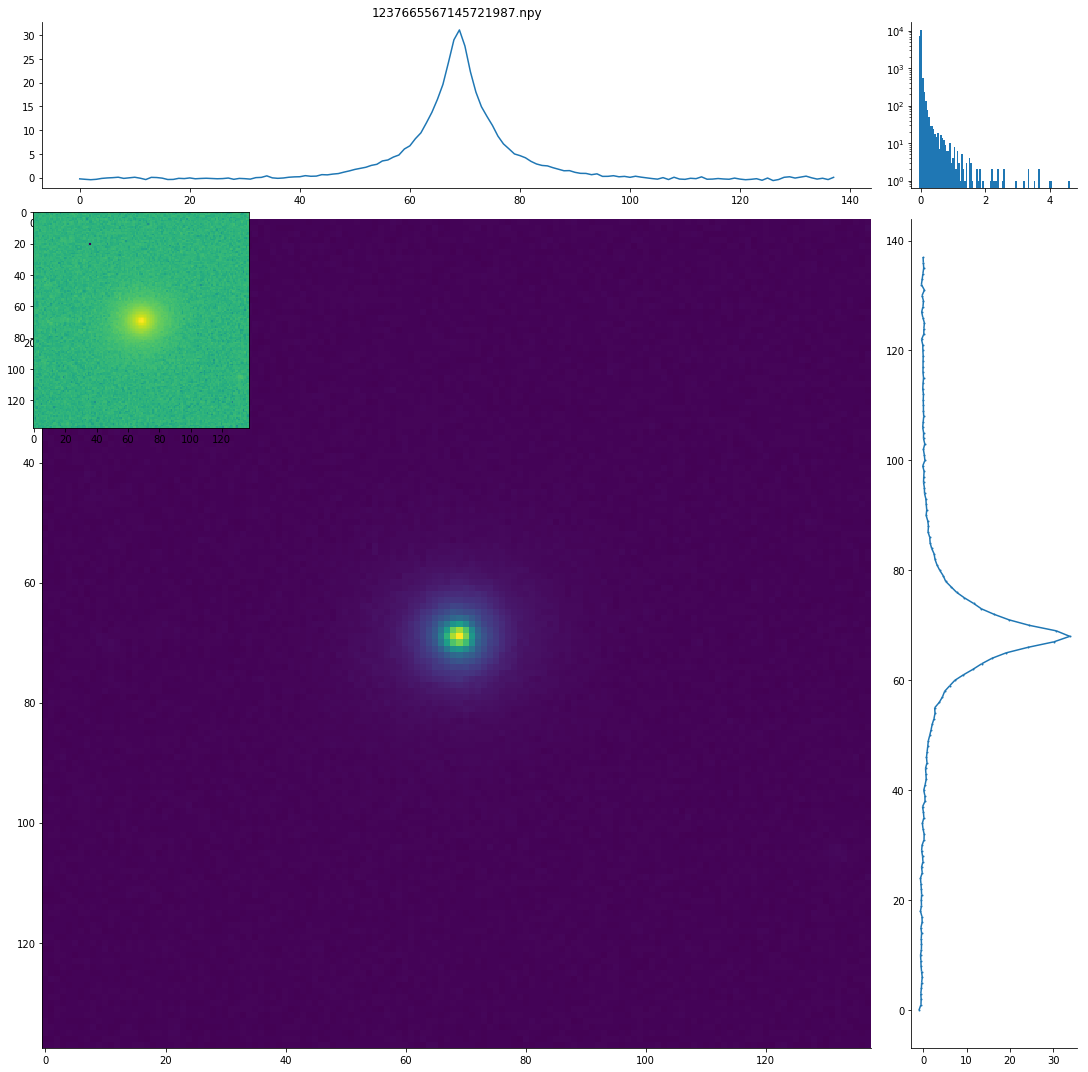

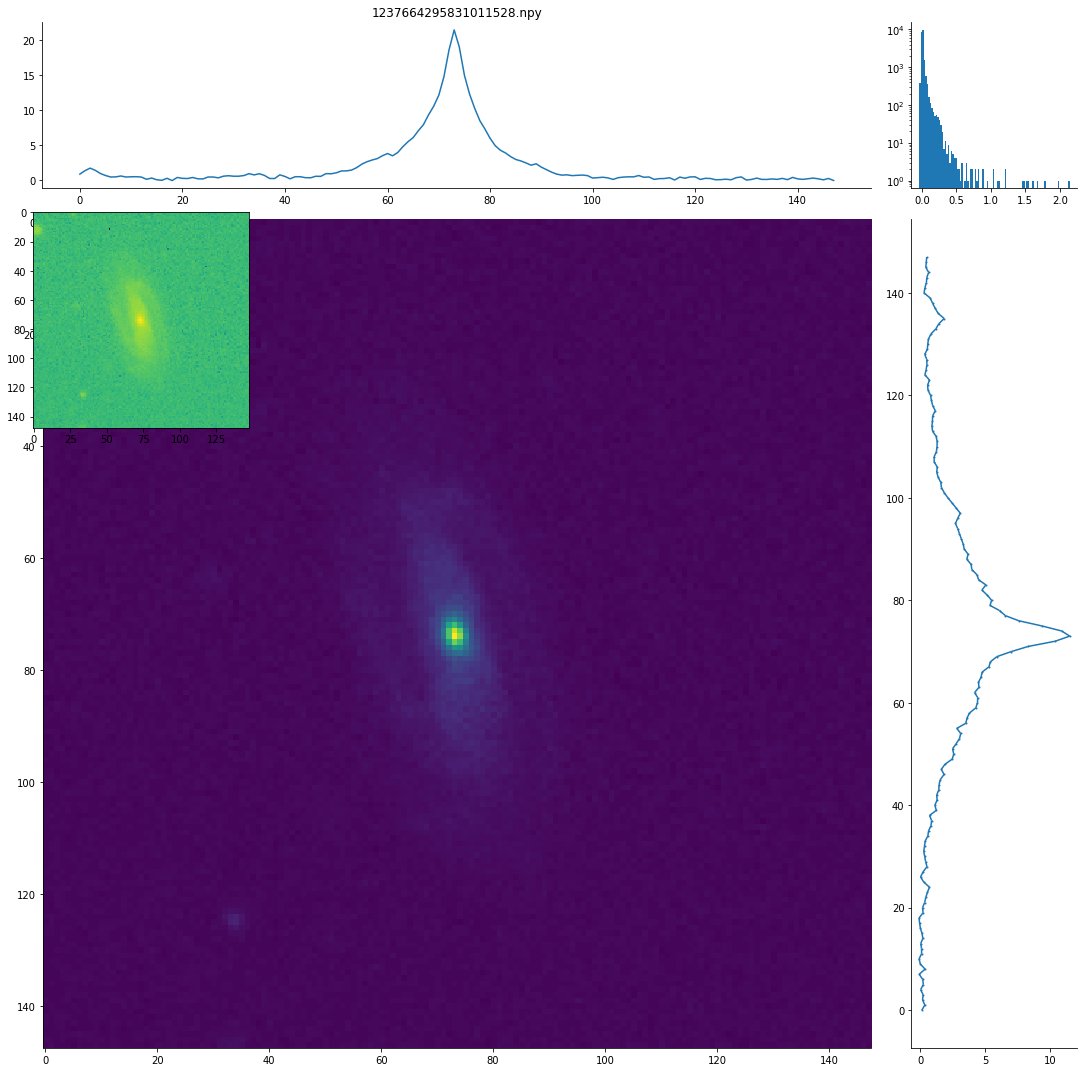

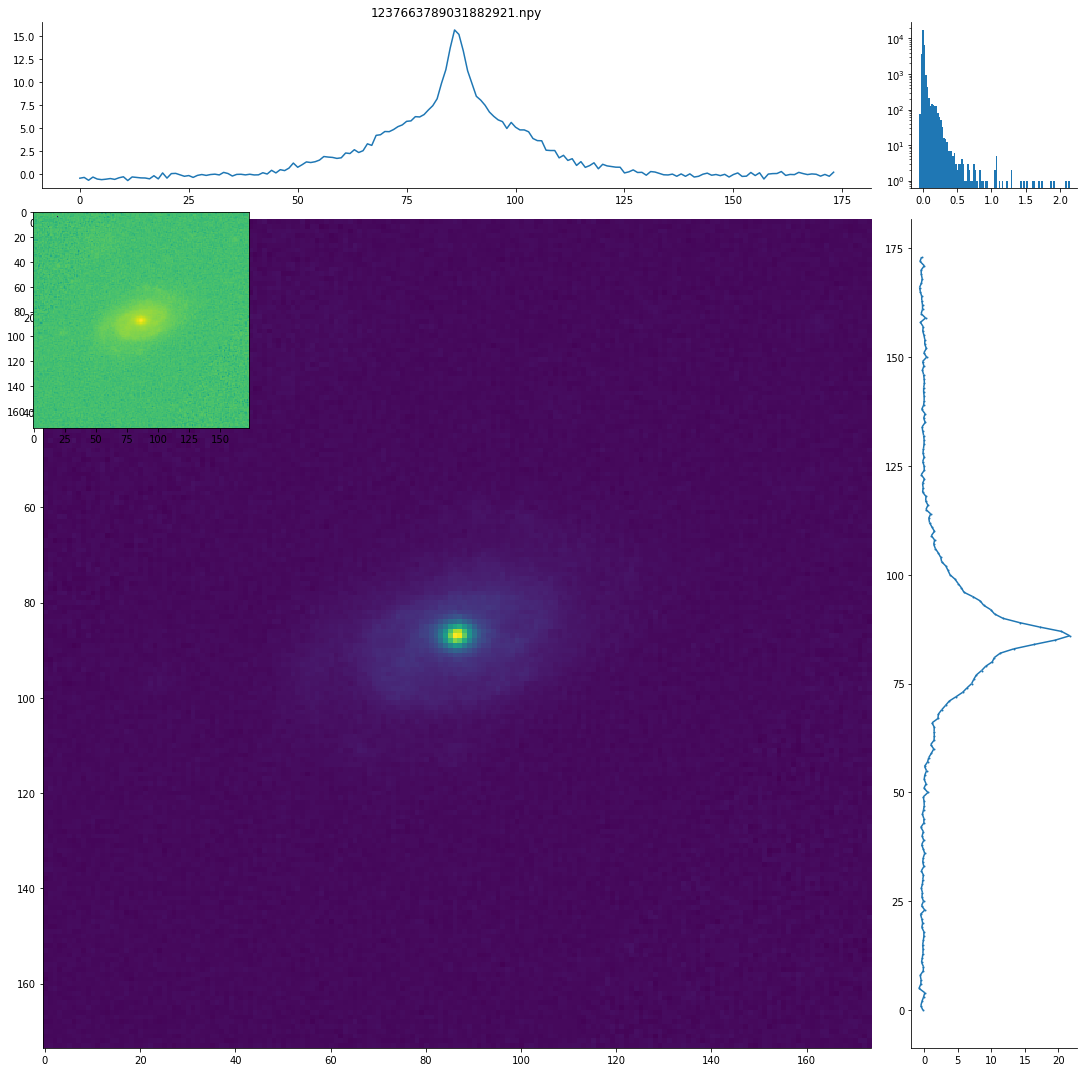

In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
    drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [11]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop half
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg):
#    Xg = cleanupImage(id)
    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id):
    Xg = read_image(id)
    return img_preprocnoread(Xg)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


-2.18632 18.958
[[ 0.71140045  0.71178049  0.7126013   0.50061888 -0.04576864]
 [ 0.52338499  0.56656128  0.65982211  0.5182029   0.00748659]
 [ 0.11727158  0.25288787  0.54581904  0.55618447  0.12251789]
 [-0.07907292  0.0913101   0.45933741  0.55213648  0.21243392]
 [ 0.05421952  0.16873983  0.41610369  0.48204201  0.2628831 ]]


1

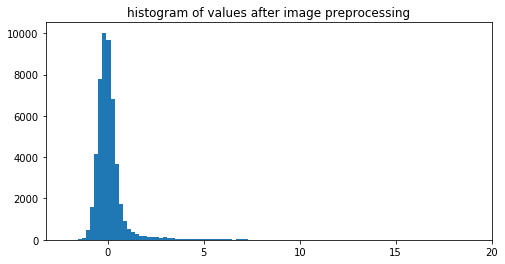

In [12]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [13]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [14]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [15]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [16]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [17]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [18]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [19]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237665440980009110,197.65770,28.63377,0.426580,0.0572,30.419029,245.14285581452506,0.475394,11.142,0.011,245.142856,1.386756e+11,3.512436e+09,True
1,1237661811736969308,182.59455,11.68940,0.489779,0.0628,38.345019,269.1428469760077,0.521937,10.943,0.029,269.142847,8.770008e+10,5.856170e+09,True
2,1237663918413709536,118.24395,53.52856,0.446684,0.0192,10.691793,82.285718194076,0.159573,9.665,0.055,82.285718,4.623810e+09,5.855694e+08,True
3,1237656494569423517,342.68055,13.10857,0.478630,0.0805,48.033609,344.9999966791698,0.669043,10.275,0.037,344.999997,1.883649e+10,1.604787e+09,True
4,1237659162276135160,243.95370,38.66495,0.575440,0.0712,51.077462,305.1428496837616,0.591750,11.086,0.031,305.142850,1.218990e+11,8.701165e+09,True


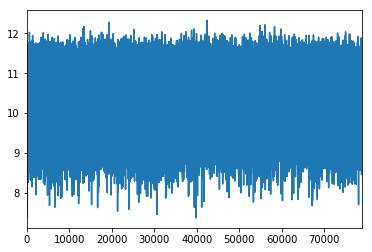

In [20]:
df.logMstar.plot()

In [21]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [22]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)
prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

chunkSize = 500
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


In [23]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [24]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78851
70965
500
sp-newSource-ReadLog1pNormCrop.75


In [25]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [26]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [27]:
reloadImagesAndPreprocess = 0
maxChunkNumber = math.ceil(len(ids)/chunkSize)

Xg3r50 = []
Xg3vgg16 = []
postImgFeatures = []
csize=2
preImgFeatures = []

chunkStart = 0
# for chunkStart in tqdm(range(0, 3)):
for chunkStart in tqdm(range(0, len(ids), chunkSize)):
    curChunk = int((chunkStart//chunkSize))
    valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

    Xg_ = []
    pre_ex_ = []

    # preprocess the image and collect some raw image stats
    for i in range(chunkStart, chunkStart+valuesInThisChunk):
        X = read_image(ids[i])
        Xg_.append(img_preprocnoread(X))
        pre_ex_.append([
            X.sum(),
            X.min(),
            X.max(),
            X.mean(),
            X.std(),
            X[X.shape[0]//2,X.shape[1]//2],
            np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
            X.shape[0], 
        ])

    # reformat the postprocessing
    pre_ex = np.stack(pre_ex_)
    Xg = np.stack(Xg_)

    # collect some post processing stats
    post_ex = np.hstack([
        np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
        np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
        ])

    Xg3 = np.zeros((valuesInThisChunk,224,224,3))
    Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)
    
    # do r50 prediction
    Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
    Xg3vgg16_ = vgg16.predict(Xg3)


    if chunkStart == 0:
        Xg3r50 = Xg3r50_
        Xg3vgg16 = Xg3vgg16_
        preImgFeatures = pre_ex
        postImgFeatures = post_ex
    else:
        Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
        Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
        preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
        postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)
        
print('done')

postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']



100%|██████████| 158/158 [11:35<00:00,  4.27s/it]

done


In [28]:
Xg3 = None
Xg = None
X = None


In [29]:
Distance = df.Distance.values[:N].reshape(N,1)

Xg3f = np.hstack ( ( 
        Xg3r50, 
        Xg3vgg16, 
        Distance,
        1/Distance,
        Distance**2,
        1/(Distance**2),
        Distance**3,
        1/(Distance**3),
        np.log(Distance),
        1/np.log(Distance),
        np.log(Distance**2),
        1/np.log(Distance**2),
        np.log(Distance)**2,
        1/np.log(Distance)**2,
        preImgFeatures,
        postImgFeatures
        ) )

distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

In [30]:
prefixThisRound = prefixThisRound + '-model4'

In [31]:
# extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
            + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
            + [prefixThisRound+'.'+ n for n in distanceNames]
            + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
            + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

print(len(Xg3fNames), Xg3f.shape)

3075 (78851, 3075)


In [32]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((t1,t2), axis=1)
np.save(prefixThisRound+str(N), t3)
np.save(prefixThisRound+str(N) + 'featurenames', Xg3fNames)
del t1, t2, t3

(78851, 3075)
(78851, 14)


In [33]:

# if os.path.isfile(prefixThisRound +str(N)+'.npy'):
#     t3 = np.load(prefixThisRound+str(N)+'.npy')
#     Xg3fNames = np.load(prefixThisRound+str(N) + 'featurenames' + '.npy', )
# Xg3f = t3[:,1:]
# Xg3f.shape

In [34]:
# Xg3f = t3[:,1:]
# Xg3f.shape

### Generate the train/test datasets for lgbm regression

In [35]:
# N = len(df.SDSS_ID.values)
# M = 4000

# N = 10000
# M = 10000
print(M, N)

70965 78851


In [36]:
dtrain = lgbm.Dataset(Xg3f[:M], label= Y[:M])
dtest = lgbm.Dataset(Xg3f[M:], label= Y[M:])


In [37]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    #'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [38]:
# useless cv if not used
# bst=lgbm.cv(lgbm_params, dtrain, num_boost_round=10000, nfold=3, stratified=False, shuffle=True,
#               metrics=None, fobj=None, feval=None, init_model=None, feature_name='auto',
#               categorical_feature='auto', early_stopping_rounds=100, fpreproc=None,
#               verbose_eval=5, show_stdv=True, seed=0, callbacks=None)



In [39]:

# num_boost_round = len(bst['rmse-mean'])-1
num_boost_round = 29999
print(num_boost_round)


29999


In [40]:
from sklearn.metrics import *

def lgb_rmsle(y_pred,y_true):
   return 'rmsle', mean_squared_error(np.log1p(y_true.get_label()),np.log1p(y_pred)), False

In [41]:
model = lgbm.train(lgbm_params, dtrain, num_boost_round,
                   valid_sets=[dtest], valid_names=['test'], fobj=None, feval=lgb_rmsle, 
                   init_model=None, feature_name='auto', categorical_feature='auto', 
                   early_stopping_rounds=100, evals_result=None, verbose_eval=20, 
                   learning_rates=None, callbacks=None)


Training until validation scores don't improve for 100 rounds.
[20]	test's rmse: 0.560406	test's rmsle: 0.00250756
[40]	test's rmse: 0.4911	test's rmsle: 0.00193738
[60]	test's rmse: 0.434991	test's rmsle: 0.00152698
[80]	test's rmse: 0.390044	test's rmsle: 0.00123134
[100]	test's rmse: 0.35394	test's rmsle: 0.00101558
[120]	test's rmse: 0.325193	test's rmsle: 0.000857718
[140]	test's rmse: 0.302291	test's rmsle: 0.000741152
[160]	test's rmse: 0.284458	test's rmsle: 0.000655947
[180]	test's rmse: 0.270691	test's rmsle: 0.000593757
[200]	test's rmse: 0.259812	test's rmsle: 0.000546814
[220]	test's rmse: 0.250913	test's rmsle: 0.000509746
[240]	test's rmse: 0.243622	test's rmsle: 0.000480265
[260]	test's rmse: 0.237755	test's rmsle: 0.000457226
[280]	test's rmse: 0.232891	test's rmsle: 0.000438616
[300]	test's rmse: 0.228863	test's rmsle: 0.000423633
[320]	test's rmse: 0.225437	test's rmsle: 0.000411027
[340]	test's rmse: 0.222485	test's rmsle: 0.000400355
[360]	test's rmse: 0.219967	tes

[3020]	test's rmse: 0.182714	test's rmsle: 0.000270554
[3040]	test's rmse: 0.182672	test's rmsle: 0.000270429
[3060]	test's rmse: 0.182646	test's rmsle: 0.000270353
[3080]	test's rmse: 0.182622	test's rmsle: 0.000270285
[3100]	test's rmse: 0.182587	test's rmsle: 0.000270182
[3120]	test's rmse: 0.182554	test's rmsle: 0.000270092
[3140]	test's rmse: 0.182536	test's rmsle: 0.000270042
[3160]	test's rmse: 0.182505	test's rmsle: 0.000269955
[3180]	test's rmse: 0.182459	test's rmsle: 0.000269822
[3200]	test's rmse: 0.182416	test's rmsle: 0.000269694
[3220]	test's rmse: 0.182396	test's rmsle: 0.000269634
[3240]	test's rmse: 0.182349	test's rmsle: 0.000269492
[3260]	test's rmse: 0.18231	test's rmsle: 0.00026938
[3280]	test's rmse: 0.182293	test's rmsle: 0.000269334
[3300]	test's rmse: 0.182248	test's rmsle: 0.000269198
[3320]	test's rmse: 0.182232	test's rmsle: 0.000269152
[3340]	test's rmse: 0.182214	test's rmsle: 0.000269101
[3360]	test's rmse: 0.182185	test's rmsle: 0.000269015
[3380]	test'

[6020]	test's rmse: 0.179808	test's rmsle: 0.000262115
[6040]	test's rmse: 0.179805	test's rmsle: 0.000262107
[6060]	test's rmse: 0.1798	test's rmsle: 0.000262092
[6080]	test's rmse: 0.17978	test's rmsle: 0.000262038
[6100]	test's rmse: 0.179775	test's rmsle: 0.000262026
[6120]	test's rmse: 0.179767	test's rmsle: 0.000262005
[6140]	test's rmse: 0.179767	test's rmsle: 0.000262007
[6160]	test's rmse: 0.179745	test's rmsle: 0.000261946
[6180]	test's rmse: 0.179727	test's rmsle: 0.000261895
[6200]	test's rmse: 0.179715	test's rmsle: 0.000261863
[6220]	test's rmse: 0.179702	test's rmsle: 0.000261827
[6240]	test's rmse: 0.179701	test's rmsle: 0.000261822
[6260]	test's rmse: 0.179698	test's rmsle: 0.000261818
[6280]	test's rmse: 0.179686	test's rmsle: 0.000261778
[6300]	test's rmse: 0.179674	test's rmsle: 0.000261744
[6320]	test's rmse: 0.17967	test's rmsle: 0.000261731
[6340]	test's rmse: 0.17966	test's rmsle: 0.0002617
[6360]	test's rmse: 0.179635	test's rmsle: 0.000261631
[6380]	test's rms

[9020]	test's rmse: 0.178583	test's rmsle: 0.00025863
[9040]	test's rmse: 0.178576	test's rmsle: 0.00025861
[9060]	test's rmse: 0.178567	test's rmsle: 0.000258586
[9080]	test's rmse: 0.17855	test's rmsle: 0.000258534
[9100]	test's rmse: 0.178547	test's rmsle: 0.000258526
[9120]	test's rmse: 0.178541	test's rmsle: 0.00025851
[9140]	test's rmse: 0.178534	test's rmsle: 0.00025849
[9160]	test's rmse: 0.178529	test's rmsle: 0.000258476
[9180]	test's rmse: 0.17852	test's rmsle: 0.000258449
[9200]	test's rmse: 0.178505	test's rmsle: 0.000258405
[9220]	test's rmse: 0.178501	test's rmsle: 0.000258394
[9240]	test's rmse: 0.178506	test's rmsle: 0.000258409
[9260]	test's rmse: 0.178492	test's rmsle: 0.000258366
[9280]	test's rmse: 0.178483	test's rmsle: 0.000258342
[9300]	test's rmse: 0.178476	test's rmsle: 0.000258325
[9320]	test's rmse: 0.178476	test's rmsle: 0.000258325
[9340]	test's rmse: 0.178468	test's rmsle: 0.000258305
[9360]	test's rmse: 0.178463	test's rmsle: 0.000258291
[9380]	test's rm

[12000]	test's rmse: 0.177763	test's rmsle: 0.000256286
[12020]	test's rmse: 0.177755	test's rmsle: 0.00025626
[12040]	test's rmse: 0.177752	test's rmsle: 0.00025625
[12060]	test's rmse: 0.177747	test's rmsle: 0.000256236
[12080]	test's rmse: 0.177741	test's rmsle: 0.000256218
[12100]	test's rmse: 0.177741	test's rmsle: 0.000256216
[12120]	test's rmse: 0.17774	test's rmsle: 0.000256214
[12140]	test's rmse: 0.177734	test's rmsle: 0.000256196
[12160]	test's rmse: 0.177723	test's rmsle: 0.000256163
[12180]	test's rmse: 0.177725	test's rmsle: 0.000256169
[12200]	test's rmse: 0.177714	test's rmsle: 0.000256134
[12220]	test's rmse: 0.177716	test's rmsle: 0.000256143
[12240]	test's rmse: 0.177713	test's rmsle: 0.000256135
[12260]	test's rmse: 0.177712	test's rmsle: 0.000256133
[12280]	test's rmse: 0.177705	test's rmsle: 0.000256112
[12300]	test's rmse: 0.177705	test's rmsle: 0.00025611
[12320]	test's rmse: 0.177704	test's rmsle: 0.000256109
[12340]	test's rmse: 0.177701	test's rmsle: 0.000256

[14940]	test's rmse: 0.177215	test's rmsle: 0.000254757
[14960]	test's rmse: 0.177207	test's rmsle: 0.000254735
[14980]	test's rmse: 0.177205	test's rmsle: 0.000254728
[15000]	test's rmse: 0.177203	test's rmsle: 0.000254724
[15020]	test's rmse: 0.177199	test's rmsle: 0.000254711
[15040]	test's rmse: 0.177197	test's rmsle: 0.000254705
[15060]	test's rmse: 0.177193	test's rmsle: 0.000254695
[15080]	test's rmse: 0.177193	test's rmsle: 0.000254695
[15100]	test's rmse: 0.177186	test's rmsle: 0.000254672
[15120]	test's rmse: 0.177185	test's rmsle: 0.000254672
[15140]	test's rmse: 0.177184	test's rmsle: 0.00025467
[15160]	test's rmse: 0.177181	test's rmsle: 0.000254661
[15180]	test's rmse: 0.177173	test's rmsle: 0.000254637
[15200]	test's rmse: 0.177168	test's rmsle: 0.000254623
[15220]	test's rmse: 0.177161	test's rmsle: 0.000254603
[15240]	test's rmse: 0.177156	test's rmsle: 0.000254588
[15260]	test's rmse: 0.177156	test's rmsle: 0.000254588
[15280]	test's rmse: 0.177155	test's rmsle: 0.000

In [42]:
pred = model.predict(Xg3f[M:])

In [43]:
print(Y[M:].shape)
print(pred.shape)

(7886,)
(7886,)


In [44]:
chiSq = xi2(Y[M:],pred,err[M:])
linChiSq = xi2(10**Y[M:],10**pred,err_lin[M:])
print(chiSq)
print(linChiSq)


66.7288440316
76.8328009721


In [45]:
print(N,(M,N-M), prefixThisRound, chiSq, linChiSq)
# 7885 (6308, 1577) sp-newSource-ReadNormCrop.5-model1 65.6004981632 289.265891446
# 78851 (63080, 15771) sp-newSource-ReadNormCrop.5-model1 101.26977686 3634.92854724
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1 84.7537916939 112.786722095
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1-model2 76.9540798979 106.544584929
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.5-model3 64.4120566007 82.1151002172
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 72.2302974915 78.0009050209
# 78851 (70965, 7886) sp-newSource-ReadLog1pCrop.75Norm-model4 74.433987693 104.167079904
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 66.7288440316 76.8328009721

78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 66.7288440316 76.8328009721


In [46]:
# investigateIDOffset = 2815

# df.loc[M+investigateIDOffset,:]

# print(10**pred[investigateIDOffset]/10**Y[M+investigateIDOffset], 10**Y[M+investigateIDOffset])

# drawOneGalaxy(df.loc[M+investigateIDOffset,'SDSS_ID'])

In [47]:
# def xi2_max(true,pred,error):
#     s=np.argmax((true-pred)**2/error**2)
    
#     plt.hist(np.log(0.00001+(true-pred)**2/error**2),bins=100)
#     return s

In [48]:
# # M = N-4000
# pred[2815] = Y[M+2815]

# print( xi2_max(10**Y[M:],10**pred,err_lin[M:]))


In [49]:
# kf = KFold(n_splits=5,shuffle=True, random_state=220673)


# for tix, vix in kf.split(x[:-1]):
#        X_train, X_test = x[tix], x[vix]
#        Y_train, Y_test = y[tix], y[vix]

# lgb_train = lgb.Dataset(X_train, Y_train, categorical_feature=cat)
#        lgb_eval = lgb.Dataset(X_test, Y_test, categorical_feature=cat)

# gbm = lgb.train(params,
#                        lgb_train,
#                        num_boost_round=10000,
#                        valid_sets=[lgb_train,lgb_eval],  # eval training data
#                        #categorical_feature=
#                        verbose_eval=100,
#                        early_stopping_rounds=1000,
#                        feval=lgb_r2,
#                        categorical_feature=cat
#                       )


# def lgb_r2(y_pred,y_true):
#    return ‘r2’, r2_score(y_true.get_label(),y_pred), True


# [6:28] 
# gbm.predict(X_test,gbm.best_iteration)

# Model is trained, values are obtained, saving and result analysis below

In [50]:
# break here, save the stuff below

In [51]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

(3075,)


3048

In [52]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)[:50]

[(4594, 'sp-newSource-ReadLog1pNormCrop.75-model4.D'),
 (3015, 'sp-newSource-ReadLog1pNormCrop.75-model4.1/D'),
 (2915, 'sp-newSource-ReadLog1pNormCrop.75-model4.norm.flux.sum'),
 (2375, 'sp-newSource-ReadLog1pNormCrop.75-model4.width'),
 (1921, 'sp-newSource-ReadLog1pNormCrop.75-model4.pre.flux.std'),
 (1751, 'sp-newSource-ReadLog1pNormCrop.75-model4.pre.flux.sum'),
 (1558, 'sp-newSource-ReadLog1pNormCrop.75-model4.pre.flux.mean'),
 (1165, 'sp-newSource-ReadLog1pNormCrop.75-model4.pre.aroundCenter.flux'),
 (998, 'sp-newSource-ReadLog1pNormCrop.75-model4.center.flux'),
 (900, 'sp-newSource-ReadLog1pNormCrop.75-model4.aroundCenter.flux'),
 (855, 'sp-newSource-ReadLog1pNormCrop.75-model4.pre.flux.min'),
 (562, 'sp-newSource-ReadLog1pNormCrop.75-model4.pre.center.flux'),
 (467, 'sp-newSource-ReadLog1pNormCrop.75-model4.norm.flux.std'),
 (378, 'sp-newSource-ReadLog1pNormCrop.75-model4.r50.108'),
 (375, 'sp-newSource-ReadLog1pNormCrop.75-model4.vgg16.794'),
 (310, 'sp-newSource-ReadLog1pNor

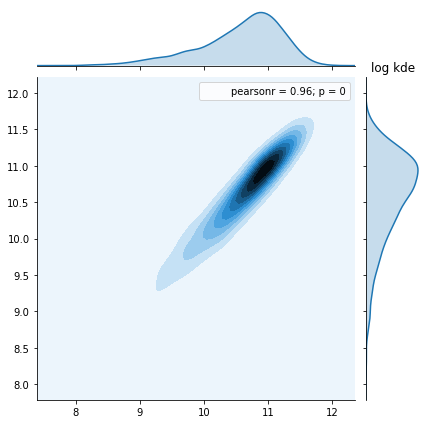

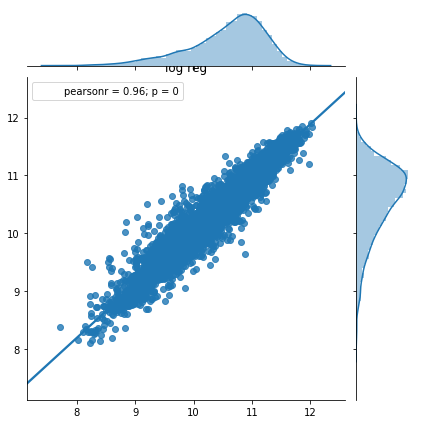

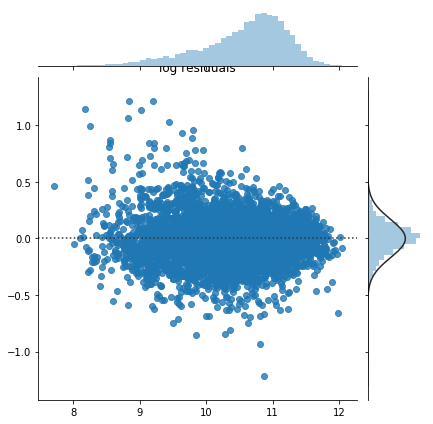

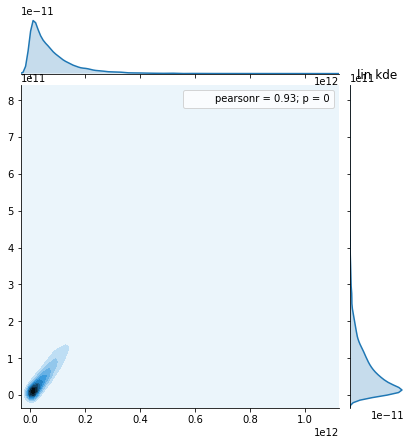

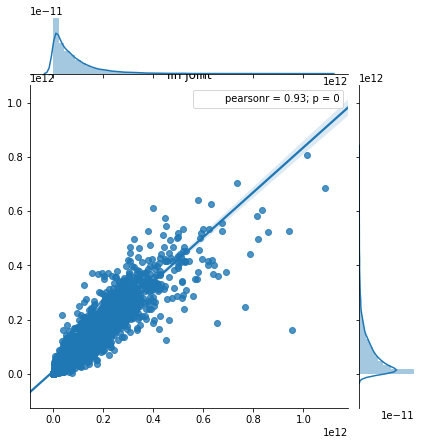

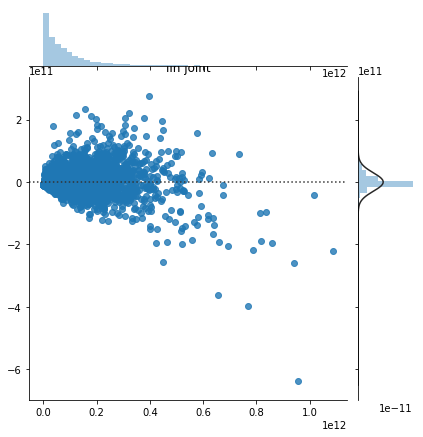

In [53]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
plt.title('log kde')
sns.jointplot(x=Y[M:], y=pred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y[M:], y=pred, kind='resid')
plt.title('log residuals')


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
plt.title('lin kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='reg')
plt.title('lin joint')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='resid')
plt.title('lin joint')
# plt.scatter(x=10**Y[M:], y=10**pred)


11.98 11.2063732874
954992586021.0 160832305467.0
SDSS_ID         1237657775542698092
RA                          134.274
DEC                         40.0137
D25                        0.645654
redshi                       0.0964
GalSize_kpc                 77.5937
D_Mpc             413.1428578070232
d_pix_kpc                  0.801189
logMstar                      11.98
err_logMstar                  0.004
Distance                    413.143
lin_mass                9.54993e+11
lin_err                 8.79581e+09
hasFile                        True
Name: 75930, dtype: object
1237657775542698092


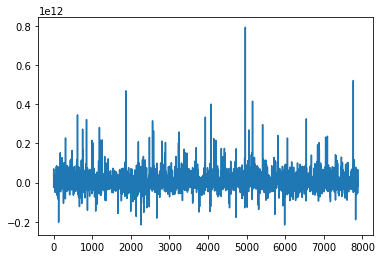

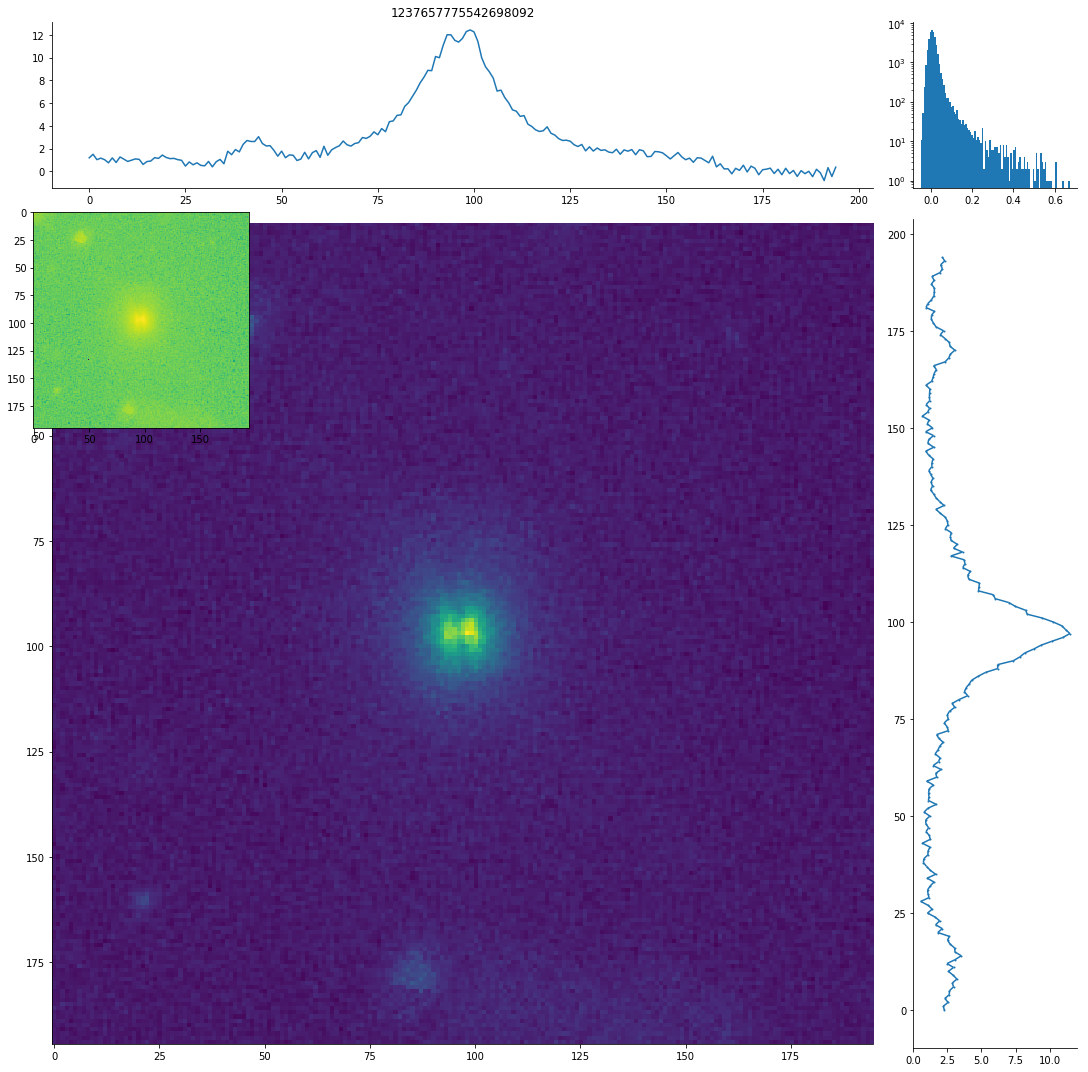

In [54]:
plt.plot(10**Y[M:]-10**pred)
worstID = np.argmax(10**Y[M:]-10**pred)

print(Y[M+worstID], pred[worstID])
print(10**Y[M+worstID], 10**pred[worstID])
print(df.loc[M+worstID,:]) # 1237664105244524770, 1237661851469611060
drawOneGalaxy(df.loc[M+worstID,'SDSS_ID'])